# Wearable step counter

## Data import, filtering, and fixing

### import

In [28]:
import pandas as pd
import openpyxl

# get the step counter data from the data file
data_file: str = './resources/femaleWalk.xlsx'
walk_df = pd.read_excel(data_file)
display(walk_df.head())
display(walk_df.tail())

# final row in data file says "finish Activity Duration : 2 minutes12seconds"
# 132s, 50Hz --> 6600 data points. But there are 8320 records in the dataset, so the actual data
# says 8321 data points (zero indexed minus summary line), 132s --> 63.03787879Hz --> 63.0Hz

,accdatax,accdatay,accdataz,magdatax,magdatay,magdataz,gyrodatax,gyrodatay,gyrodataz,lightdatax
0,-3.154818,0.445217,8.612317,-1.7690,-38.3690,-25.772501,0.069248,-0.154476,0.015980,1824.0
1,-3.154818,0.445217,8.612317,1.1895,-42.5475,-25.772501,0.063921,-0.138495,0.029297,1824.0
2,-3.154818,0.445217,8.612317,1.1895,-42.5475,-25.772501,0.045277,-0.098545,0.058594,1824.0
3,-3.308011,0.847349,8.459125,1.1895,-42.5475,-25.772501,0.047941,-0.074574,0.069248,1824.0
4,-3.308011,0.847349,8.459125,1.1895,-42.5475,-25.772501,0.037287,-0.031960,0.079901,1824.0


,accdatax,accdatay,accdataz,magdatax,magdatay,magdataz,gyrodatax,gyrodatay,gyrodataz,lightdatax
8317,-3.240989,3.001625,7.836778,29.9815,-23.3630,-15.5855,0.221060,0.000000,0.005327,1068.0
8318,-3.240989,3.001625,7.836778,26.9620,-26.3825,-19.1845,0.306288,0.013317,-0.010653,1068.0
8319,-3.260138,2.676090,8.468699,26.9620,-26.3825,-19.1845,0.340912,0.010653,-0.026634,1068.0
8320,-3.260138,2.676090,8.468699,26.9620,-26.3825,-19.1845,0.221060,-0.007990,-0.047941,1068.0
8321,finish Activity Duration : 2 minutes12seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### fixing and filtering

In [30]:
# check data types
from numpy import float64
from pydantic import BaseModel, FiniteFloat

# we only need the accelerometer data from the 3 axes, so...
walk_df = walk_df[['accdatax', 'accdatay', 'accdataz']]
# remove the summary row
walk_df = walk_df.iloc[:-1]
# show dtypes
# print(walk_df.dtypes)
# convert the accdatax column to float
walk_df['accdatax'] = walk_df['accdatax'].astype('float64')
print(walk_df.dtypes)

display(walk_df.head())
display(walk_df.tail())

class AccData(BaseModel):
    accdatax: FiniteFloat # invalidates inf, -inf, and nan
    accdatay: FiniteFloat
    accdataz: FiniteFloat

for index, row in walk_df.iterrows():
    try:
        AccData(**row.to_dict())
    except Exception as e:
        print(e)


accdatax    float64
accdatay    float64
accdataz    float64
dtype: object


,accdatax,accdatay,accdataz
0,-3.154818,0.445217,8.612317
1,-3.154818,0.445217,8.612317
2,-3.154818,0.445217,8.612317
3,-3.308011,0.847349,8.459125
4,-3.308011,0.847349,8.459125


,accdatax,accdatay,accdataz
8315,-3.240989,3.001625,7.836778
8316,-3.240989,3.001625,7.836778
8317,-3.240989,3.001625,7.836778
8318,-3.240989,3.001625,7.836778
8319,-3.260138,2.676090,8.468699


### display data on one plot

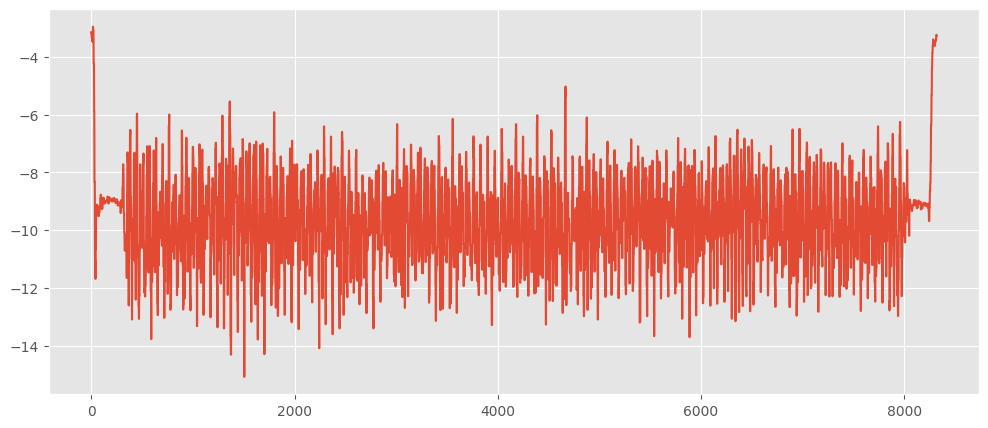

In [67]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')

x_df = walk_df['accdatax']
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# plt.figure(figsize=(12, 8))
# ax[0,0].plot(x_df)
ax.plot(x_df)
plt.show()


There seems to be some beginning and ending event in the data, separate from the walking pattern (perhaps an act of getting up and sitting down, or switch bounce in the measurement device), so we'll use a sample from the middle of the dataset...

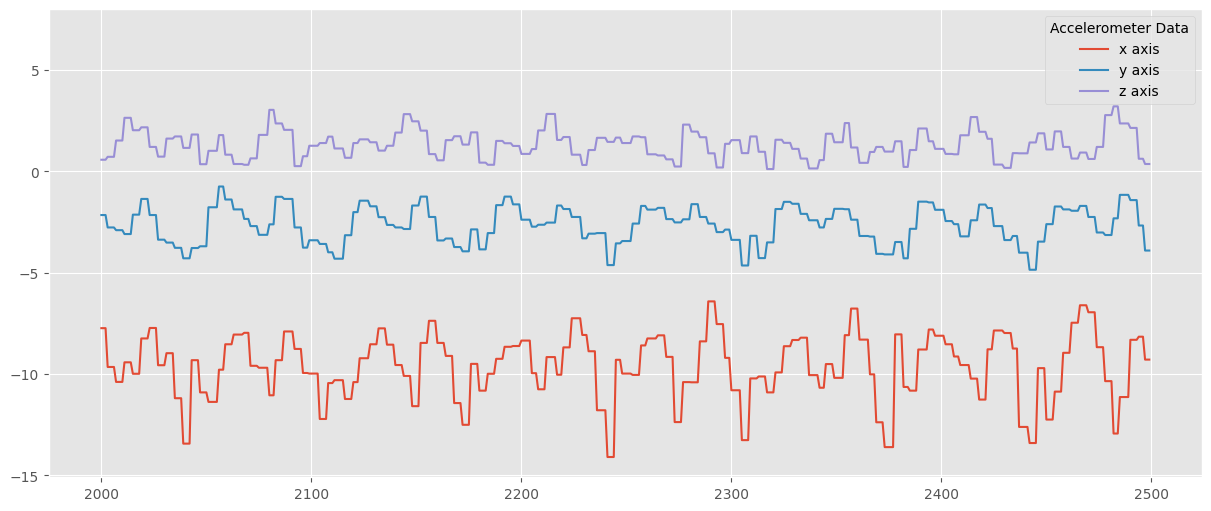

In [72]:
walk_sample_df = walk_df.iloc[2000:2500]
x_sample_df = walk_sample_df['accdatax']
y_sample_df = walk_sample_df['accdatay']
z_sample_df = walk_sample_df['accdataz']
sample_index = walk_sample_df.index
fig, ax = plt.subplots(1, 1, figsize=(12, 5), constrained_layout=True)
ax.plot(sample_index, x_sample_df, label='x axis')
ax.plot(sample_index, y_sample_df, label='y axis')
ax.plot(sample_index, z_sample_df, label='z axis')
min_y: float = min(x_sample_df.min(), y_sample_df.min(), z_sample_df.min()) - 1.0
ax.set_ylim(bottom=min_y, top=8.0)
ax.legend(title='Accelerometer Data', loc='upper right')
plt.show()

There appears to be a base signal for each of the accelerometers plus some jitter.
We'll perform a fast Fourier transform on each signal in order to determine how best to filter out the higher-frequency (lower amplitude) jitter.

sample count: 500
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38]


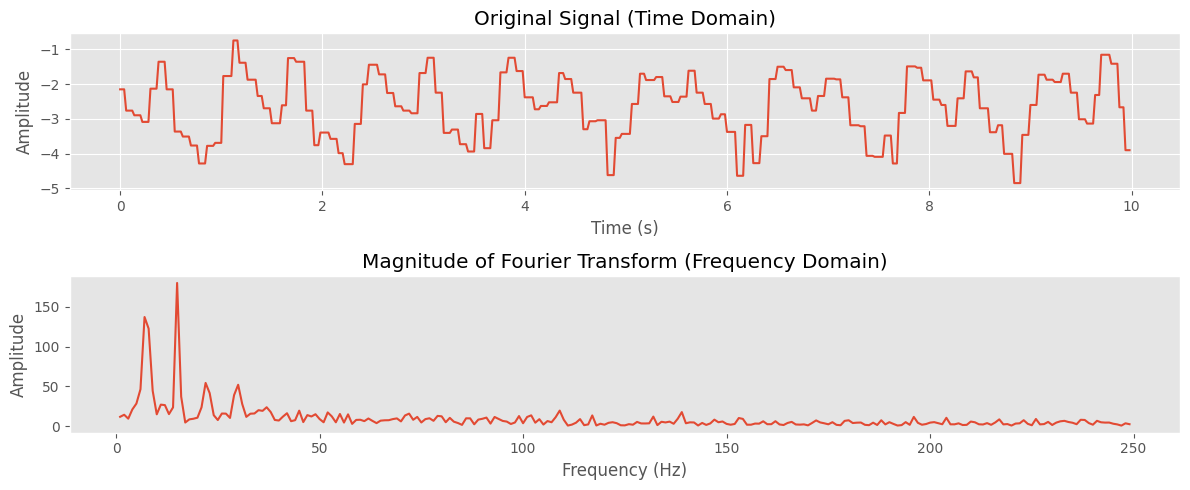

In [76]:
import numpy as np

# we'll choose a sampling frequency about 10x the sensor sample frequency
fft_sample_freq = 500
fft_sample_interval = 1 / fft_sample_freq
# we need time data for the independent axis (in place of sample index)
# well trust the datasheet and take the sampling rate to be 50Hz
# so each sample index maps to a time delta of (1/50)s
sample_count = len(walk_sample_df)
print(f"sample count: {sample_count}")
time_series = np.arange(0, sample_count / 50, 1 / 50)
print(time_series[:20])
fft_y = np.fft.fft(y_sample_df)
fft_y_freq = np.fft.fftfreq(len(time_series), fft_sample_interval)
fft_magnitude = np.abs(fft_y)

positive_freq_indices = fft_y_freq > 0
fft_y_freq = fft_y_freq[positive_freq_indices]
fft_magnitude = fft_magnitude[positive_freq_indices]

plt.figure(figsize=(12, 5))

plt.subplot(2,1, 1)
plt.plot(time_series, y_sample_df, label='y axis')
plt.title("Original Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2,1,2)
plt.plot(fft_y_freq, fft_magnitude)
plt.title("Magnitude of Fourier Transform (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# TODO: apply a moving average filter OR filter out all but the two largest frequencies indicated in the FFT.